### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
import seaborn as sns

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

### Loading RCE data and initializing lists

In [4]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 290, 311, 5 )
means, p99s, rad = read_RCE_files( path )

csf_bins_list = [ [] for i in np.arange( len(mean_RCE) ) ]
pmean_list = [ [] for i in np.arange( len(mean_RCE) ) ]
perror_list = [ [] for i in np.arange( len(mean_RCE) ) ]
p99_list = [ [] for i in np.arange( len(p99s) ) ]

m_list = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list = [ [] for i in np.arange( len(mean_RCE) ) ]
m_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]
a_list2 = [ [] for i in np.arange( len(mean_RCE) ) ]

### CSF-precip relationship for MCS across percentiles

In [5]:
# exponential fit between CSF and precipitation
def monoexp(x, m, a):
    return m * np.exp(a * x)

In [6]:
pc2 = 99
for iterator, array in enumerate( means ):
    csf_RCE = array['csf'].to_numpy()
    pmean_RCE = array['p_rate'].to_numpy()

    csf_bins, pmean_vals, _, p99_vals, _, p_error, _, _ = \
        bin_stat_function( 50, 0.25, 1, csf_RCE, pmean_RCE, pc2=pc2, threshold=10 )
    
    csf_bins_list[iterator] = csf_bins
    pmean_list[iterator] = pmean_vals
    p99_list[iterator] = p99_vals
    perror_list[iterator] = p_error
    
    # fit an exponential to the mean CSF-Precip relationship and assess goodness-of-fit
    # CSF input to the curve_fit is a decimal not a percentage, hence /100.
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., pmean_vals[i], p0 )
    m, a = params
    m_list[iterator] = m
    a_list[iterator] = a
    
    squaredDiffs = np.square(pmean_vals[i] - monoexp(csf_bins[i]/100., m, a))
    squaredDiffsFromMean = np.square(pmean_vals[i] - np.mean(pmean_vals[i]))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print( rSquared )
    print( str(m) + ' ' + str(a) )
    
    # fit an exponential to the max CSF-Precip relationship
    p0 = [ 1, 11 ]
    i = np.where( ~np.isnan(csf_bins) )
    params, cv = scipy.optimize.curve_fit( monoexp, csf_bins[i]/100., p99_vals[i], p0 )
    m, a = params
    m_list2[iterator] = m
    a_list2[iterator] = a
    print( str(m) + ' ' + str(a) )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

0.9372890998369098
0.00035724283020546386 1215.3569955820828
0.050874019089524124 670.6267229772552
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9564595823153973
6.213166189926617e-05 1414.4311699976913
0.008423775040143385 914.2456140206519
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9670970928582016
2.45895792004581e-05 1535.701518681443
0.004163184924753561 1010.8918132815674
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.978915559910967
4.8465552757798945e-06 1744.8700858733946
0.0006694719166213857 1244.8780768459524
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.9565416348835059
0.00010799459898154075 1376.6807163875178
0.006301451948010649 989.3898147307802
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
# now combine all CSF, precipitation, and cluster size values across the three files where there is minimal SST dependence
csf_RCE = RCE_concat( means, 'csf' )
pmean_RCE = RCE_concat( means, 'p_rate' )
rad_RCE = np.concatenate( [r for r in rad], axis=0 )
nbin=40

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for smallest systems
csf_bins_0, pmean_vals_0, _, p99_vals_0, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE, pmean_RCE, pc2=pc2, threshold=10 )
i = np.where( ~np.isnan(csf_bins_0) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_0[i]/100, pmean_vals_0[i], p0 )
m_0, a_0 = params
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_0[i]/100, p99_vals_0[i], p0 )
m_02, a_02 = params

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for smallest systems
loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
csf_bins_small, pmean_vals_small, _, p99_vals_small, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE[rad_RCE <= loo], pmean_RCE[rad_RCE <= loo], pc2=pc2, threshold=10 )
i = np.where( ~np.isnan(csf_bins_small) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_small[i]/100, pmean_vals_small[i], p0 )
m_small, a_small = params
params, _ = scipy.optimize.curve_fit( monoexp, csf_bins_small[i]/100, p99_vals_small[i], p0 )
m_small2, a_small2 = params
print(m_small,a_small)

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for larger systems
csf_bins_large, pmean_vals_large, _, p99_vals_large, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csf_RCE[rad_RCE >= upp], pmean_RCE[rad_RCE >= upp], pc2=pc2, threshold=10 )
i = np.where( ~np.isnan(csf_bins_large) )
params, cv = scipy.optimize.curve_fit( monoexp, csf_bins_large[i]/100, pmean_vals_large[i], p0 )
m_large, a_large = params
params, _ = scipy.optimize.curve_fit( monoexp, csf_bins_large[i]/100, p99_vals_large[i], p0 )
m_large2, a_large2 = params
print(m_large,a_large)

3.404115020807773e-05 1522.455861633322
1.241135785856072e-05 1608.5985414153745


In [26]:
print('For CSF bins for 70% or greater, how do mean and extreme precipitation shift between the smallest and largest MCSs?')
i=28
print( csf_bins_small[i:-2] )
print( np.nanmedian( (pmean_vals_small[i:-2]-pmean_vals_large[i:-2])/pmean_vals_small[i:-2] ) )
print( np.nanmean( (pmean_vals_small[i:-2]-pmean_vals_large[i:-2])/pmean_vals_small[i:-2] ) )
print( pmean_vals_small[i:-2]-pmean_vals_large[i:-2] )
print( '~~~~~~~~~~~~~~~~~~~~~~~~~' )
print( csf_bins_large[i:-1] )
print( np.nanmedian(p99_vals_small[i:-1]-p99_vals_large[i:-1]) )
print( np.nanmean(p99_vals_small[i:-1]-p99_vals_large[i:-1]) )
print( p99_vals_small[i:-1]-p99_vals_large[i:-1] )

For CSF bins for 70% or greater, how do mean and extreme precipitation shift between the smallest and largest MCSs?
[0.79806453 0.81698567 0.83628178 0.85535121 0.87390602 0.89120233
 0.91196352        nan        nan        nan]
0.20731988224762832
0.23116322302343723
[2.22971461 1.57400317 2.5689818  5.12971428 3.11653175 5.57106813
 7.18512133        nan        nan        nan]
~~~~~~~~~~~~~~~~~~~~~~~~~
[0.79803509 0.818075   0.83690351 0.85632133 0.87496269 0.89324611
 0.91179377        nan        nan        nan        nan]
6.097280516039767
6.473539170644116
[ 8.30305867  5.18123442  4.35762214  2.18125295  8.09537876  6.09728052
 11.09894673         nan         nan         nan         nan]


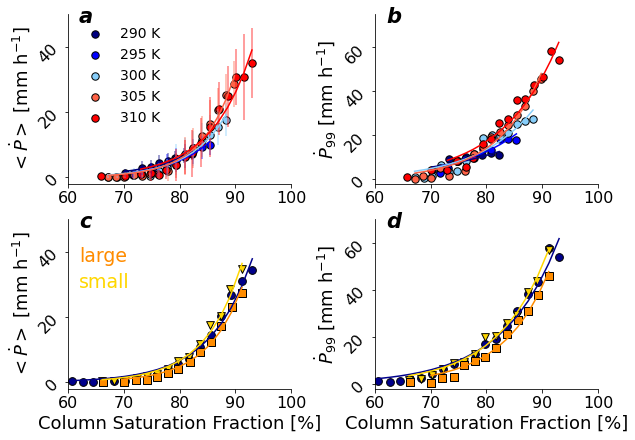

In [18]:
fig, ax = plt.subplots( 2, 2, figsize =(8.5, 6), constrained_layout=True )

ylab = [ r'$<\dot{P}>$ [mm h$^{-1}$]', r'$\dot{P}_{99}$ [mm h$^{-1}$]', r'$<\dot{P}>$ [mm h$^{-1}$]',
        r'$\dot{P}_{99}$ [mm h$^{-1}$]' ]
xlab = [ '', '', 'Column Saturation Fraction [%]', 'Column Saturation Fraction [%]' ]
fs = 16
lw=1.5

plt.rcParams.update({
    'font.size':fs,
    'axes.labelsize':fs+2,
    'xtick.labelsize':fs,
    'ytick.labelsize':fs,
    'legend.fontsize':fs-2,
})

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [60, 100] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = xlab[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    if i == 0:
        for j, k, l, m, n, o in zip(csf_bins_list, pmean_list, np.arange(len(csf_bins_list)), perror_list, m_list, a_list):
            y = monoexp( j/100, n, o )
            axis.plot( j*100, y, lw=lw, color=BR_color_cycle[l], zorder=10 )
            axis.scatter( j*100, k, color = BR_color_cycle[l], s=55, edgecolor='black', label=str(ssts[l])+' K'  )
            axis.errorbar( j*100, k, xerr=None, yerr=m, alpha=0.5, color = BR_color_cycle[l], ls='none' )
            axis.legend( frameon=False,loc='upper left' )
        axis.text( 0.05, 0.95, 'a', weight='bold', style='italic', fontsize=fs+5, transform=axis.transAxes )
        axis.set_ylim([-2,50])
    elif i == 1:
        for j, k, l, o, p in zip(csf_bins_list, p99_list, np.arange(len(csf_bins_list)), m_list2, a_list2):
            y = monoexp( j/100, o, p )
            axis.plot( j*100, y, lw=lw, color=BR_color_cycle[l], zorder=10 )
            axis.scatter( j*100, k, color = BR_color_cycle[l], s=55, edgecolor='black', label=str(ssts[l])+' K' )
        axis.text( 0.05, 0.95, 'b', weight='bold', style='italic', fontsize=fs+5, transform=axis.transAxes )
        axis.set_ylim([-2,75])
    elif i == 2:
        axis.scatter( csf_bins_0*100, pmean_vals_0, s=60, edgecolor='black', color='darkblue' )
        y = monoexp( csf_bins_0/100, m_0, a_0 )
        axis.plot( csf_bins_0*100, y, lw=lw, color='darkblue' )
        
        axis.scatter( csf_bins_small*100, pmean_vals_small, s=60, marker='v', edgecolor='black', color='gold' )
        y = monoexp( csf_bins_small/100, m_small, a_small )
        axis.plot( csf_bins_small*100, y, lw=lw, color='gold' )
        
        axis.scatter( csf_bins_large*100, pmean_vals_large, s=60, marker='s', edgecolor='black', color='darkorange' )
        y = monoexp( csf_bins_large/100, m_large, a_large )
        axis.plot( csf_bins_large*100, y, lw=lw, color='darkorange' )
        
        axis.text( 0.05, 0.6, r'small', color='gold', fontsize=fs+3, transform=axis.transAxes )
        axis.text( 0.05, 0.75, r'large', color='darkorange', fontsize=fs+3, transform=axis.transAxes )
        axis.text( 0.05, 0.95, 'c', weight='bold', style='italic', fontsize=fs+5, transform=axis.transAxes )
        axis.set_ylim([-2,50])
    elif i == 3:
        axis.scatter( csf_bins_0*100, p99_vals_0, s=60, edgecolor='black', color='darkblue' )
        y = monoexp( csf_bins_0/100, m_02, a_02 )
        axis.plot( csf_bins_0*100, y, lw=lw, color='darkblue' )
        
        axis.scatter( csf_bins_small*100, p99_vals_small, s=60, marker='v', edgecolor='black', color='gold' )
        y = monoexp( csf_bins_small/100, m_small2, a_small2 )
        axis.plot( csf_bins_small*100, y, lw=lw, color='gold' )
        
        axis.scatter( csf_bins_large*100, p99_vals_large, s=60, marker='s', edgecolor='black', color='darkorange' )
        y = monoexp( csf_bins_large/100, m_large2, a_large2 )
        axis.plot( csf_bins_large*100, y, lw=lw, color='darkorange' )
        
        axis.text( 0.05, 0.95, 'd', weight='bold', style='italic', fontsize=fs+5, transform=axis.transAxes )
        axis.set_ylim([-2,70]) #axis.set_ylim([-2,150]) for p99s

#plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-RCE-percentiles.pdf', bbox_inches='tight' )
plt.show()

### Fig S9 -- CSF-precip relationship for MCS across portions of the column

In [19]:
csfBL_RCE = RCE_concat( means, 'csf_BL' )
csfTROP1_RCE = RCE_concat( means, 'csf_TROP1' )
csfTROP2_RCE = RCE_concat( means, 'csf_TROP2' )
csfTROP3_RCE = RCE_concat( means, 'csf_TROP3' )
pmean_RCE = RCE_concat( means, 'p_rate' )
nbin=40

# create bins in column saturation fraction and evaluate corresponding precipitation percentiles for different strata
csf_bins_BL, pmean_vals_BL, _, p99_vals_BL, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfBL_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP1, pmean_vals_TROP1, _, p99_vals_TROP1, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP1_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP2, pmean_vals_TROP2, _, p99_vals_TROP2, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP2_RCE, pmean_RCE, pc2=pc2, threshold=10 )
csf_bins_TROP3, pmean_vals_TROP3, _, p99_vals_TROP3, _, _, _, _ = \
    bin_stat_function( nbin, 0.25, 1, csfTROP3_RCE, pmean_RCE, pc2=pc2, threshold=10 )

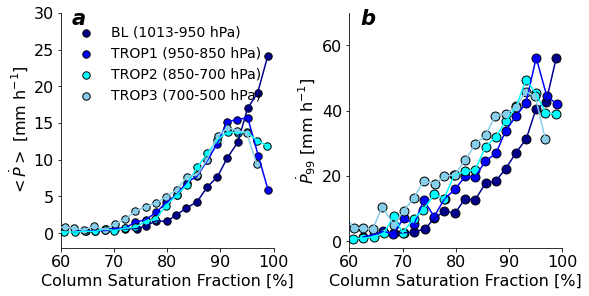

In [23]:
fig, ax = plt.subplots( 1, 2, figsize=(8,4), constrained_layout=True )
sz = 55

ax[0].text( 0.05, 0.95, 'a', style='italic', weight='bold', fontsize=fs+5, transform=ax[0].transAxes )
ax[0].scatter( csf_bins_BL*100, pmean_vals_BL, s=sz, edgecolor='black', color='darkblue', label='BL (1013-950 hPa)' )
ax[0].scatter( csf_bins_TROP1*100, pmean_vals_TROP1, s=sz, edgecolor='black', color='blue', label='TROP1 (950-850 hPa)' )
ax[0].scatter( csf_bins_TROP2*100, pmean_vals_TROP2, s=sz, edgecolor='black', color='cyan', label='TROP2 (850-700 hPa)' )
ax[0].scatter( csf_bins_TROP3*100, pmean_vals_TROP3, s=sz, edgecolor='black', color='skyblue', label='TROP3 (700-500 hPa)' )
ax[0].plot( csf_bins_BL*100, pmean_vals_BL, color='darkblue', zorder=10 )
ax[0].plot( csf_bins_TROP1*100, pmean_vals_TROP1, color='blue', zorder=10 )
ax[0].plot( csf_bins_TROP2*100, pmean_vals_TROP2, color='cyan', zorder=10 )
ax[0].plot( csf_bins_TROP3*100, pmean_vals_TROP3, color='skyblue', zorder=10 )
ax[0].set_xlim( [60, 100] )
ax[0].legend( frameon=False )
ax[0].set_ylabel( r'$<\dot{P}>$ [mm h$^{-1}$]', fontsize=fs )
ax[0].set_ylim([-2,30])

ax[1].text( 0.05, 0.95, 'b', weight='bold', style='italic', fontsize=fs+5, transform=ax[1].transAxes )
ax[1].scatter( csf_bins_BL*100, p99_vals_BL, s=80, edgecolor='black', color='darkblue' )
ax[1].scatter( csf_bins_TROP1*100, p99_vals_TROP1, s=80, edgecolor='black', color='blue' )
ax[1].scatter( csf_bins_TROP2*100, p99_vals_TROP2, s=80, edgecolor='black', color='cyan' )
ax[1].scatter( csf_bins_TROP3*100, p99_vals_TROP3, s=80, edgecolor='black', color='skyblue' )
ax[1].plot( csf_bins_BL*100, p99_vals_BL, color='darkblue', label='BL (953-1007 hPa)' )
ax[1].plot( csf_bins_TROP1*100, p99_vals_TROP1, color='blue', label='TROP1 (867-937 hPa)' )
ax[1].plot( csf_bins_TROP2*100, p99_vals_TROP2, color='cyan', label='TROP2 (713-833 hPa)' )
ax[1].plot( csf_bins_TROP3*100, p99_vals_TROP3, color='skyblue', label='TROP3 (521-671 hPa)' )
ax[1].set_xlim( [60, 100] )
ax[1].set_ylabel( r'$\dot{P}_{99}$ [mm h$^{-1}$]', fontsize=fs )
ax[1].set_ylim([-2,70])

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel( 'Column Saturation Fraction [%]', fontsize=fs )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/S9-csf-precip-RCE-layers.pdf', bbox_inches='tight' )
plt.show()